## Bayesian Optimization with multiple objectives
Our pipeline should be as follows:
1. Define our design space as a grid or hyperplane etc
2. Define a model as surrogate to compute a score between target and a response query
3. Define acquistion function to score candidates
4. Define a selector to select candidate points
4. Define the optimization routine for the problem

In [1]:
import os
import torch
import time
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
import pdb
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

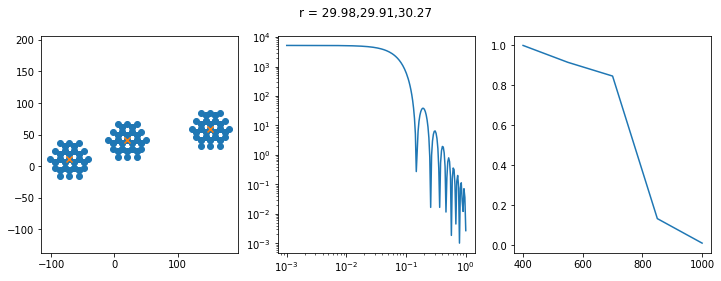

In [2]:
"""Generate a target spectrum
We simulate a target spectrum with a fixed number of spehre's with 
radii sampled from a narrow lognormal distribution
"""
import head

sim = head.Emulator()
fig, axs = plt.subplots(1,3,figsize=(4*3,4))
R_mu = 1
R_sigma = 1e-2
sim.make_structure(r_mu=R_mu,r_sigma=R_sigma)
sim.plot_structure2d(ax=axs[0])

q, st = sim.get_saxs()
axs[1].loglog(q, st)
fig.suptitle('r = '+','.join('%.2f'%i for i in sim.step*sim.radii))

wl, It = sim.get_spectrum()
axs[2].plot(wl,It)
plt.show()

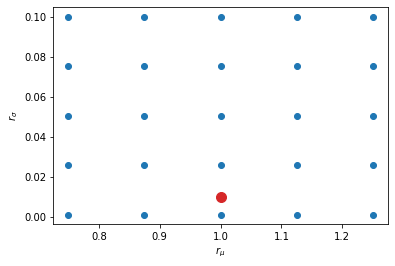

In [3]:
"""
create a search space as a grid of mu and sigma values of lognormal radii distribution

"""
import numpy as np

NUM = 5
X = np.linspace(0.75,1.25, num=NUM) 
Y = np.linspace(1e-3,1e-1, num=NUM)
grid = head.Grid(X,Y)
fig, ax = plt.subplots()
ax.scatter(grid.points[:,0], grid.points[:,1], label='Grid points')
ax.scatter(R_mu, R_sigma, s=100, color='tab:red', label='Target')
ax.set_xlabel(r'$r_{\mu}$')
ax.set_ylabel(r'$r_{\sigma}$')
plt.show()

In [4]:
from head.metrics import euclidean_dist

def oracle(x):
    """Scoring function between two spectra
    Given two spectra in si, st compute a score between them.
    Note that here si, st are represented using the class `head.UVVis`.
    If you are using arrays, you'd have to make necessary transformations.
    """
    x_np = x.numpy()
    sim.make_structure(r_mu=x_np[0],r_sigma=x_np[1])
    q, si = sim.get_saxs()
    wl, Ii = sim.get_spectrum()
    dist_sas = euclidean_dist(np.log10(si),np.log10(st))
    dist_uvvis = euclidean_dist(Ii,It)
    return torch.from_numpy(np.asarray([-dist_sas, -dist_uvvis]))

def batch_oracle(x):
    out = []
    for xi in x.squeeze(1):
        out.append(oracle(xi))
    return torch.stack(out, dim=0)

In [5]:
problem = lambda s : batch_oracle(s).to(**tkwargs)
ref_point = torch.tensor([0,0]).to(**tkwargs)

In [6]:
def generate_initial_data(n=6):
    points = torch.from_numpy(grid.points)
    soboleng = torch.quasirandom.SobolEngine(dimension=1)
    train_xid = torch.floor(soboleng.draw(n)*len(grid)).to(**tkwargs)
    train_x = points[train_xid.long(),:]
    train_obj = problem(train_x)
    
    return torch.squeeze(train_x), torch.squeeze(train_obj)

train_x, train_obj = generate_initial_data(n=6)


In [7]:
# 2. define your model
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    model = SingleTaskGP(train_x, train_obj)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

mll, model = initialize_model(train_x, train_obj)

In [8]:
# 3. Define acqusition function
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.sampling.samplers import SobolQMCNormalSampler

partitioning = NondominatedPartitioning(ref_point=ref_point, Y=train_obj)
MC_SAMPLES = 128
sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)


acq_fun = lambda model: qExpectedHypervolumeImprovement(
    model=model,
    ref_point=ref_point.tolist(),  # use known reference point 
    partitioning=partitioning,
    sampler=sampler,
)


In [9]:
# 4. define a optimization routine for acqusition function 
from botorch.optim.optimize import optimize_acqf_discrete
from botorch.utils.transforms import unnormalize

BATCH_SIZE = 4 

def selector(f, q = BATCH_SIZE):
    choices = torch.from_numpy(grid.points)
    new_x, _ = optimize_acqf_discrete(
        acq_function = f,
        q=q,
        choices = choices
    )
    new_obj = problem(new_x)
    return new_x, new_obj


In [10]:
# 5. define the opitmization loop

from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume

torch.manual_seed(0)


N_ITERATIONS = 25

verbose = False
hv = Hypervolume(ref_point=ref_point)

hvs_all = []
hvs = []

# compute pareto front
pareto_mask = is_non_dominated(train_obj)
pareto_y = train_obj[pareto_mask]

# compute hypervolume
volume = hv.compute(pareto_y)
hvs.append(volume)

# run N_ITERATIONS rounds of BayesOpt after the initial random batch
for iteration in range(1, N_ITERATIONS + 1):    
    
    # fit the models
    fit_gpytorch_model(mll)

    # define the acquisition modules using a QMC sampler
    acquisition = acq_fun(model)

    # optimize acquisition functions and get new observations
    new_x, new_obj = selector(acquisition)

    # update training points
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])

    # compute pareto front
    pareto_mask = is_non_dominated(train_obj)
    pareto_y = train_obj[pareto_mask]
    
    # compute hypervolume
    volume = hv.compute(pareto_y)
    hvs.append(volume)

    # reinitialize the models so they are ready for fitting on next iteration
    # Note: we find improved performance from not warm starting the model hyperparameters
    # using the hyperparameters from the previous iteration
    mll, model = initialize_model(train_x, train_obj)

    print(".", end="")

    hvs_all.append(hvs)


.........................

Text(0.5, 1.0, 'Iteration')

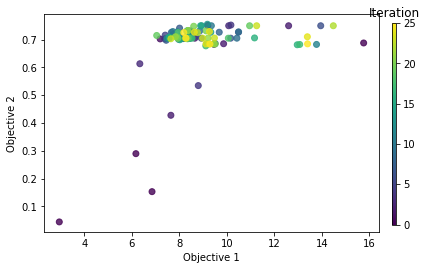

In [11]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

fig, axes = plt.subplots(1, 1)
cm = plt.cm.get_cmap('viridis')

batch_number = torch.cat(
    [torch.zeros(6), torch.arange(1, N_ITERATIONS+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]
).numpy()

sc = axes.scatter(train_obj[:, 0].cpu().numpy(), train_obj[:,1].cpu().numpy(), 
    c=batch_number, alpha=0.8,
)
axes.set_xlabel("Objective 1")
axes.set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")

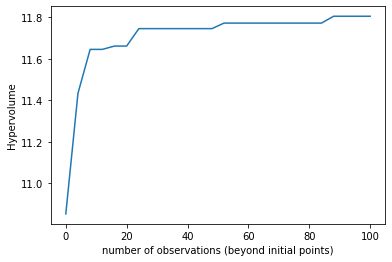

In [12]:
iters = np.arange(N_ITERATIONS + 1) * BATCH_SIZE

fig, ax = plt.subplots()

ax.plot(
    iters, np.asarray(hvs_all).mean(axis=0), linewidth=1.5,
)

ax.set(xlabel='number of observations (beyond initial points)', ylabel='Hypervolume')
plt.show()

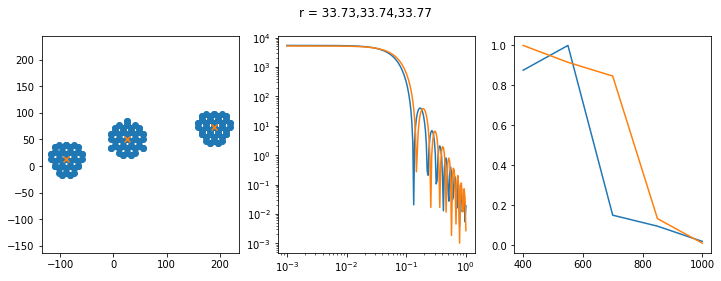

In [13]:
opt_x, opt_obj = selector(acquisition,q=1)
opt = opt_x.numpy().squeeze()
fig, axs = plt.subplots(1,3,figsize=(4*3,4))
sim.make_structure(r_mu=opt[0],r_sigma=opt[1])
sim.plot_structure2d(ax=axs[0])

q, sopt = sim.get_saxs()
axs[1].loglog(q, sopt, label='Optimal')
axs[1].loglog(q, st, label='Target')
fig.suptitle('r = '+','.join('%.2f'%i for i in sim.step*sim.radii))

wl, Iopt = sim.get_spectrum()
axs[2].plot(wl,Iopt, label='Optimal')
axs[2].plot(wl,It, label='Target')
plt.show()